In [1]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import dill
import matplotlib.pyplot as plt
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
import lovely_tensors as lt
lt.monkey_patch()

import csng
from csng.models.inverted_encoder import InvertedEncoder, InvertedEncoderBrainreader
from csng.models.ensemble import EnsembleInvEnc
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder
from csng.models.inverted_encoder_decoder import InvertedEncoderDecoder
from csng.utils.mix import seed_all, check_if_data_zscored, update_config_paths, update_config
from csng.utils.data import standardize, normalize, crop
from csng.utils.comparison import find_best_ckpt, load_decoder_from_ckpt, plot_reconstructions, plot_metrics, eval_decoder, SavedReconstructionsDecoder, collect_all_preds_and_targets
from csng.losses import get_metrics
from csng.data import get_dataloaders, get_sample_data
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader
from csng.mouse_v1.encoder import get_encoder as get_encoder_sensorium_mouse_v1
from csng.cat_v1.encoder import get_encoder as get_encoder_cat_v1

# from monkeysee.SpatialBased.decoding_wrapper import MonkeySeeDecoder


### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

print(f"{DATA_PATH=}")
print(f"{DATA_PATH_CAT_V1=}")
print(f"{DATA_PATH_MOUSE_V1=}")
print(f"{DATA_PATH_BRAINREADER=}")

DATA_PATH='/scratch/izar/sobotka/csng'
DATA_PATH_CAT_V1='/scratch/izar/sobotka/csng/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/scratch/izar/sobotka/csng/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/scratch/izar/sobotka/csng/brainreader'


In [2]:
### setup config
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "crop_wins": dict(),
}

print(f"... Running on {config['device']} ...")
seed_all(config["seed"])

... Running on cuda ...


# Data

In [ ]:
### brainreader mouse data
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 8,
    # "sessions": list(range(1, 23)),
    "sessions": [6],
    "resize_stim_to": (36, 64),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
}

In [ ]:
### cat v1 data
config["data"]["cat_v1"] = {
    "crop_win": (20, 20),
    "dataset_config": {
        "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
        "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
        "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
        "image_size": [50, 50],
        "crop": False,
        "batch_size": 36,
        "stim_keys": ("stim",),
        "resp_keys": ("exc_resp", "inh_resp"),
        "return_coords": True,
        "return_ori": False,
        "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
        "cached": False,
        "stim_normalize_mean": 46.143,
        "stim_normalize_std": 24.960,
        "resp_normalize_mean": None,
        "resp_normalize_std": torch.load(
            os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
        ),
    },
}
# add crop_wins for cat v1 data
config["crop_wins"]["cat_v1"] = config["data"]["cat_v1"]["crop_win"]

In [3]:
### sensorium 2022 mouse v1 data
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
            # os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
            # os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
            # os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
            # os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
        ],
        "normalize": True,
        "z_score_responses": False,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 16,
        "seed": config["seed"],
        "use_cache": False,
    },
    "crop_win": (22, 36),
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 36,
    "device": config["device"],
}
### add crop_wins for mouse v1 data
for data_key, n_coords in get_dataloaders(config=config)[0]["train"]["mouse_v1"].neuron_coords.items():
    config["crop_wins"][data_key] = config["data"]["mouse_v1"]["crop_win"]

In [4]:
dls, neuron_coords = get_dataloaders(config)
for tier, data_dict in dls.items():
    print(f"{tier}:")
    for data_name, dl in data_dict.items():
        # for data_key, dset in zip(dl.data_keys, dl.datasets):
        #     config["crop_wins"][data_key] = tuple(dset[0].images.shape[-2:])
        print(f"  {data_name}: {len(dl)} batches")
        print(f"    data keys: {', '.join(dl.data_keys)}")
        print(f"    size of datasets: {', '.join([str(len(dl) * _dl.batch_size) for _dl in dl.dataloaders])}")

train:
  mouse_v1: 280 batches
    data keys: 21067-10-18
    size of datasets: 4480
val:
  mouse_v1: 33 batches
    data keys: 21067-10-18
    size of datasets: 528
test:
  mouse_v1: 3 batches
    data keys: 21067-10-18
    size of datasets: 108


Training dataset:	 4480 samples
Validation dataset:	 528 samples
Test dataset:		 108 samples

stimuli:
  torch.Size([36, 1, 36, 64])
  min=-1.750  max=2.261
  mean=0.213  std=0.948
responses:
  torch.Size([36, 8372])
  min=0.000  max=12.738
  mean=0.286  std=0.516


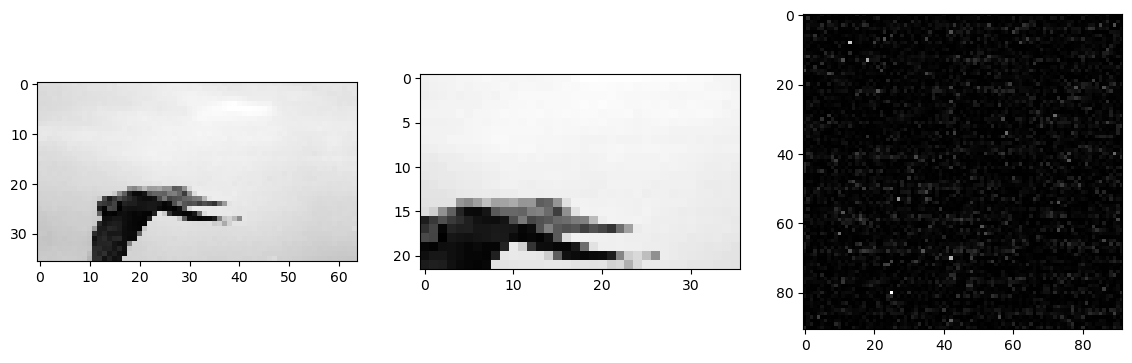

In [21]:
### show data
sample_dataset = "mouse_v1"
sample_data_key = "21067-10-18"
tier = "test"
sample_idx = 0

datapoint = next(iter(dls[tier][sample_dataset].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['train'][sample_dataset].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['val'][sample_dataset].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['test'][sample_dataset].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_wins"][sample_data_key]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")

---
# Models

## MindEye2

In [ ]:
decoder = SavedReconstructionsDecoder(
    reconstructions=torch.load(os.path.join(
        DATA_PATH,
        "mindeye",
        "evals",
        "csng_mouse_v1__24-03-25_22-50",
        "subj21067-10-18_reconstructions.pt"
    ), pickle_module=dill),
    data_key="21067-10-18",
    zscore_reconstructions=True,
    device=config["device"],
)

## GAN

In [73]:
### config for model to load
config["decoder"] = {
    "load_ckpt": {
        "load_only_core": False,
        "load_best": True,
        "load_opter_state": True,
        "load_history": True,
        "reset_best": False,
        "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2025-03-24_10-06-33", "decoder.pt"),
        "resume_checkpointing": False,
        "resume_wandb_id": None,
    },
}

def merge_configs_fn(cfg, ckpt_cfg):
    load_ckpt_cfg = deepcopy(cfg["decoder"]["load_ckpt"])
    cfg = ckpt_cfg = update_config_paths(config=ckpt_cfg, new_data_path=DATA_PATH)
    cfg["decoder"]["load_ckpt"] = load_ckpt_cfg
    return cfg, ckpt_cfg

In [ ]:
### load model
cfg, decoder, loss_fn, history, best, ckpt = init_gan_decoder(config=config, merge_configs_fn=merge_configs_fn)
_ = decoder.eval()

[INFO] Loading checkpoint from /scratch/izar/sobotka/csng/models/gan/2025-03-24_10-06-33/decoder.pt...
[INFO] Loading the best model...
[INFO] Loading the full model...
[WARNING] Loading GAN state_dict without the optimizer states.
[INFO] Loading the optimizer states...


### Collect predictions

In [77]:
### collect all predictions and targets
eval_dls, _ = get_dataloaders(config=config)
seed_all(config["seed"])
all_preds, all_targets = collect_all_preds_and_targets(
    model=decoder,
    dataloaders=eval_dls["test"],
    crop_wins=config["crop_wins"],
    device=config["device"],
)
all_preds, all_targets

({'21067-10-18': tensor[100, 1, 22, 36] n=79200 (0.3Mb) x∈[-3.653, 5.199] μ=0.385 σ=1.684},
 {'21067-10-18': tensor[100, 1, 22, 36] n=79200 (0.3Mb) x∈[-1.750, 2.261] μ=0.080 σ=0.915})

In [78]:
### load metrics
inp_zscored = check_if_data_zscored(cfg=config)
metrics = {data_key: get_metrics(
    inp_zscored=inp_zscored,
    crop_win=config["crop_wins"][data_key],
    reduction="none",
    device=config["device"]
) for data_key in config["crop_wins"].keys()}

In [79]:
### calculate metrics
losses = {data_key: {loss_fn_name: None for loss_fn_name in data_key_loss_fns.keys()} for data_key, data_key_loss_fns in metrics.items()}
for data_key in all_preds.keys():
    for loss_name, loss_fn in metrics[data_key].items():
        losses[data_key][loss_name] = loss_fn(
            all_preds[data_key],
            all_targets[data_key],
            data_key=data_key,
            sum_over_samples=False,
            mean_over_samples=False,
            phase="val",
        )

In [80]:
# results = dict()
# results["MindEye2"] = deepcopy(losses)
results["Ours"] = deepcopy(losses)

### Variance of errors

In [115]:
### average over image dimensions if needed
for method_name in results.keys():
    for sample_data_key in results[method_name].keys():
        for metric_name in results[method_name][sample_data_key].keys():
            if len(results[method_name][sample_data_key][metric_name].shape) > 1:
                print(f"Averaging over image dimensions for {method_name} {sample_data_key} {metric_name}: {results[method_name][sample_data_key][metric_name].shape}")
                results[method_name][sample_data_key][metric_name] = results[method_name][sample_data_key][metric_name].mean(dim=list(range(1, results[method_name][sample_data_key][metric_name].ndim)))

Averaging over image dimensions for MindEye2 21067-10-18 MSE: torch.Size([100, 1, 22, 36])
Averaging over image dimensions for MindEye2 21067-10-18 MSE w/out min-max normalization: torch.Size([100, 1, 22, 36])
Averaging over image dimensions for MindEye2 21067-10-18 MAE: torch.Size([100, 1, 22, 36])
Averaging over image dimensions for MindEye2 21067-10-18 MAE w/out min-max normalization: torch.Size([100, 1, 22, 36])
Averaging over image dimensions for Ours 21067-10-18 MSE: torch.Size([100, 1, 22, 36])
Averaging over image dimensions for Ours 21067-10-18 MSE w/out min-max normalization: torch.Size([100, 1, 22, 36])
Averaging over image dimensions for Ours 21067-10-18 MAE: torch.Size([100, 1, 22, 36])
Averaging over image dimensions for Ours 21067-10-18 MAE w/out min-max normalization: torch.Size([100, 1, 22, 36])


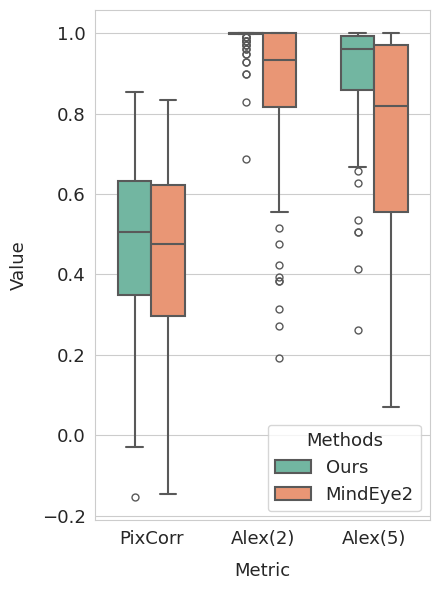

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming results is already populated with your data
methods = ["Ours", "MindEye2"]  # List of methods to compare
metric_names = ["PixCorr", "Alex(2)", "Alex(5)"]  # List of metric names
fontsize = 13

# Prepare data as a DataFrame for Seaborn
data = []
for metric in metric_names:
    for method in methods:
        losses = np.array(results[method][sample_data_key][metric]).flatten()  # Flatten if needed
        for loss in losses:
            data.append({"Metric": metric, "Method": method, "Loss": loss})

df = pd.DataFrame(data)

# Set Seaborn style
sns.set_style("whitegrid")

# Create the box plot
plt.figure(figsize=(4.5, 6))
sns.boxplot(x="Metric", 
            y="Loss", 
            hue="Method", 
            data=df,
            palette="Set2",  # Color palette for methods
            width=0.6,       # Width of boxes
            fliersize=5,     # Size of outlier markers
            linewidth=1.5)   # Line width of boxes

# Customize the plot
# plt.title('Loss distribution across metrics and methods', fontsize=fontsize + 2, pad=15)
plt.xlabel('Metric', fontsize=fontsize, labelpad=10)
plt.ylabel('Value', fontsize=fontsize, labelpad=10)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# Adjust legend
plt.legend(title="Methods", loc='best', fontsize=fontsize, title_fontsize=fontsize)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [124]:
# Print statistics for reference
for metric in results[methods[0]][sample_data_key].keys():
    print(f"\nStatistics for {metric}:")
    for method in methods:
        losses = results[method][sample_data_key][metric]
        losses = np.array(losses.cpu() if torch.is_tensor(losses) else losses).flatten()  # Flatten if needed
        print(f"  {method}:")
        # print(f"    Median: {np.median(losses):.4f}")
        # print(f"    IQR: {np.percentile(losses, 75) - np.percentile(losses, 25):.4f}")
        print(f"    Std Dev: {np.std(losses):.4f}")


Statistics for SSIM:
  Ours:
    Std Dev: 0.1169
  MindEye2:
    Std Dev: 0.0962

Statistics for Log SSIML:
  Ours:
    Std Dev: 0.0893
  MindEye2:
    Std Dev: 0.0798

Statistics for SSIML:
  Ours:
    Std Dev: 0.0585
  MindEye2:
    Std Dev: 0.0481

Statistics for PixCorr:
  Ours:
    Std Dev: 0.1963
  MindEye2:
    Std Dev: 0.2104

Statistics for PixCorr Loss:
  Ours:
    Std Dev: 0.1963
  MindEye2:
    Std Dev: 0.2104

Statistics for Alex(2):
  Ours:
    Std Dev: 0.0395
  MindEye2:
    Std Dev: 0.1905

Statistics for Alex(2) Loss:
  Ours:
    Std Dev: 0.0395
  MindEye2:
    Std Dev: 0.1905

Statistics for Alex(5):
  Ours:
    Std Dev: 0.1440
  MindEye2:
    Std Dev: 0.2608

Statistics for Alex(5) Loss:
  Ours:
    Std Dev: 0.1440
  MindEye2:
    Std Dev: 0.2608

Statistics for PL:
  Ours:
    Std Dev: 0.0371
  MindEye2:
    Std Dev: 0.0374

Statistics for FFL:
  Ours:
    Std Dev: 0.0000
  MindEye2:
    Std Dev: 0.0000

Statistics for MSE:
  Ours:
    Std Dev: 0.0273
  MindEye2:
 

### Closer inspection of errors

In [143]:
from skimage.color import rgb2gray
from torchvision import transforms

In [ ]:
### sensorium 2022
recons = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_mouse_v1__24-03-25_22-50",
    "subj21067-10-18_reconstructions_orig.pt"
))
gt_imgs = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_mouse_v1__24-03-25_22-50",
    "subj21067-10-18_all_images.pt"
))

In [173]:
### brainreader
enhancedrecons = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_19-02-25_16-52",
    "subj06_all_enhancedrecons.pt"
))
blurryrecons = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_19-02-25_16-52",
    "subj06_all_blurryrecons.pt"
))
recons = enhancedrecons * 0.75 + blurryrecons * 0.25
gt_imgs = torch.load(os.path.join(
    DATA_PATH,
    "mindeye",
    "evals",
    "csng_19-02-25_16-52",
    "subj06_all_images.pt"
))

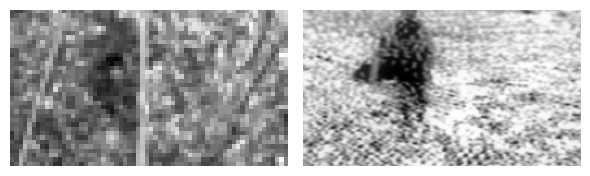

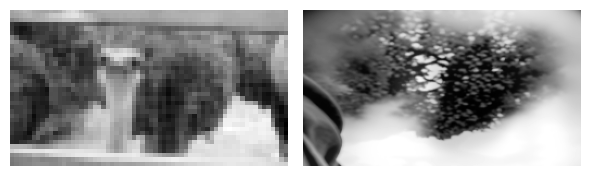

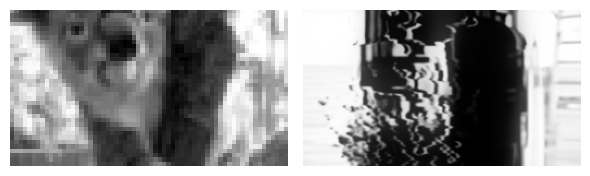

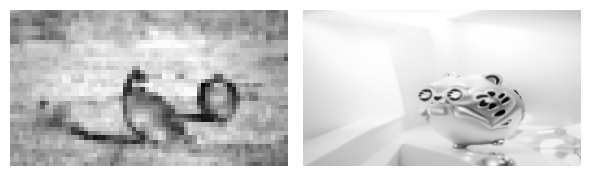

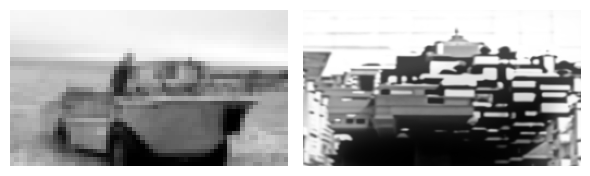

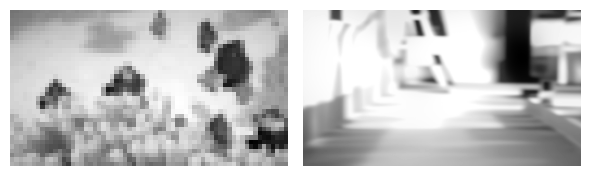

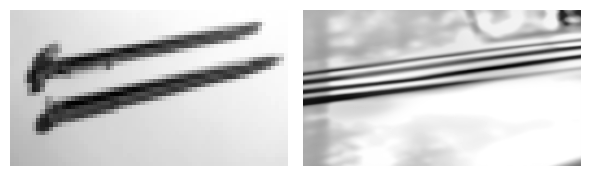

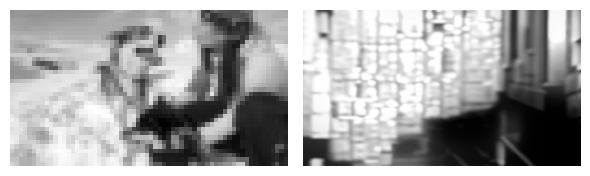

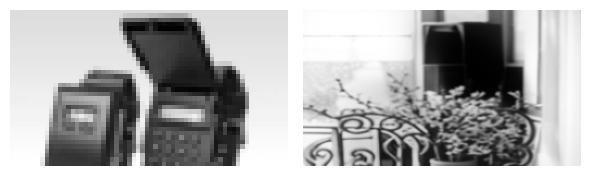

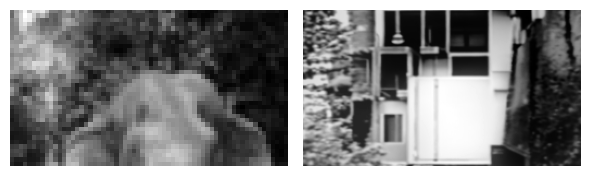

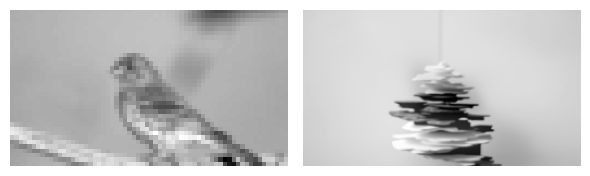

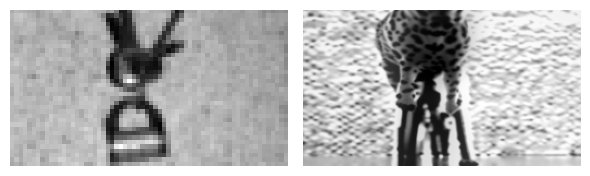

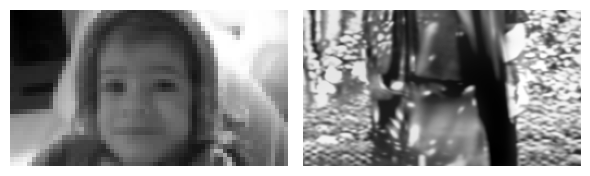

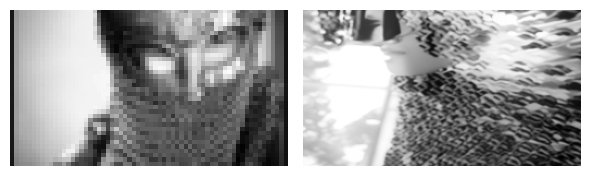

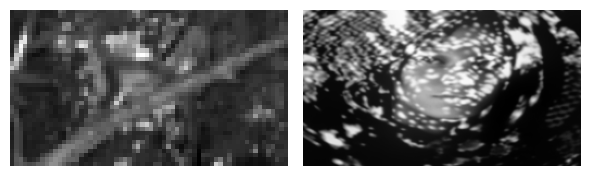

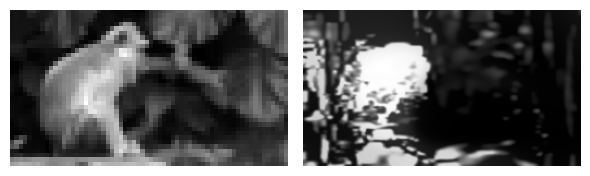

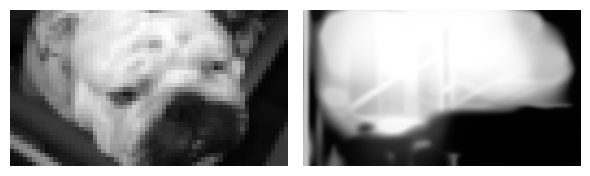

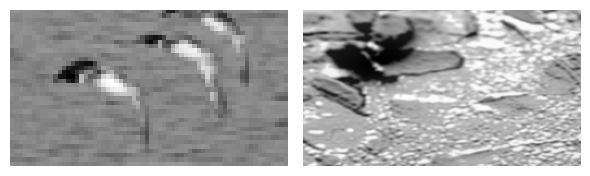

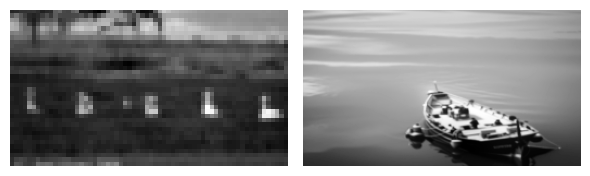

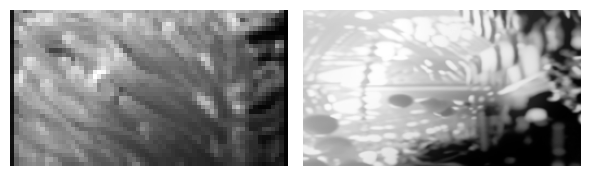

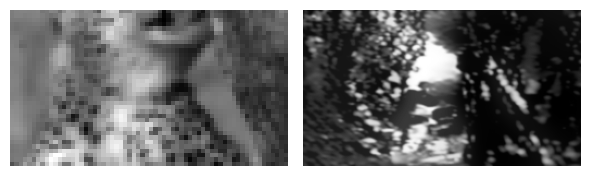

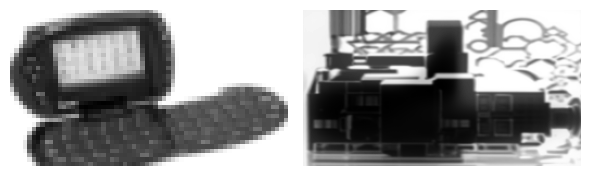

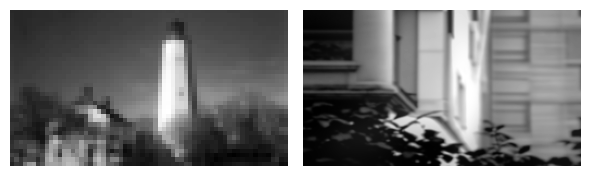

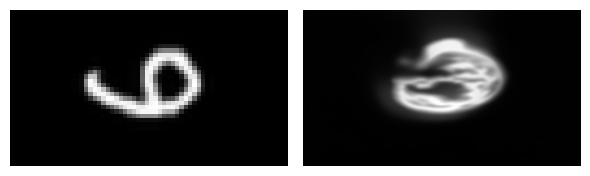

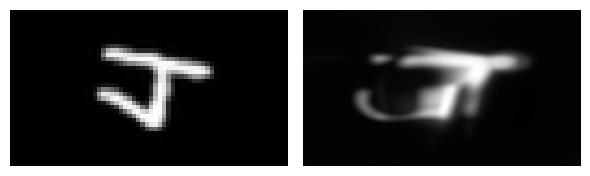

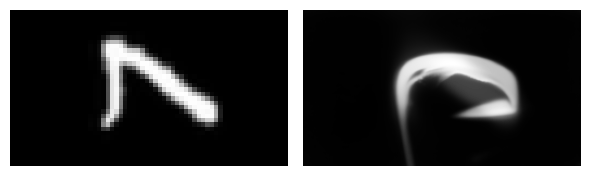

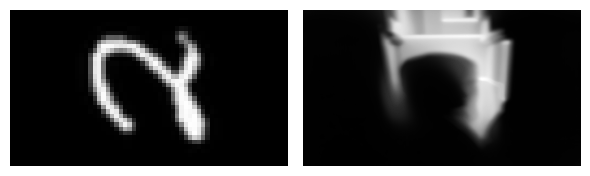

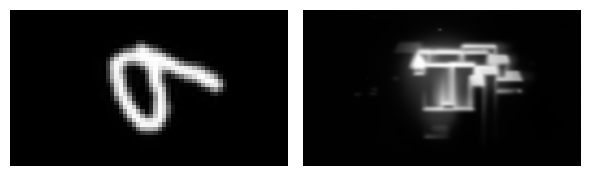

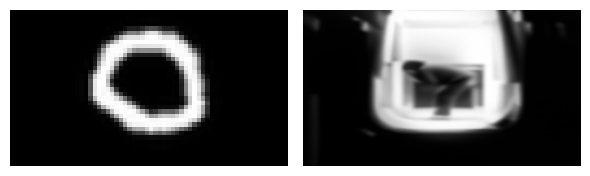

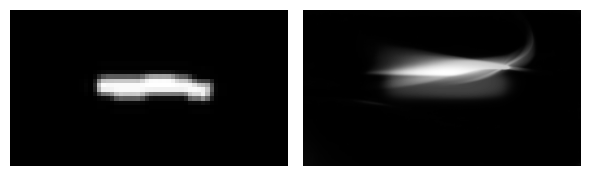

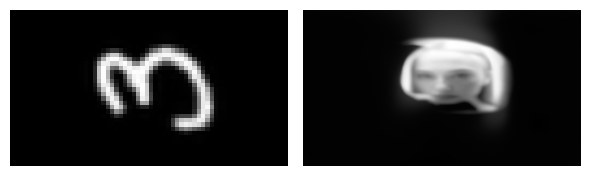

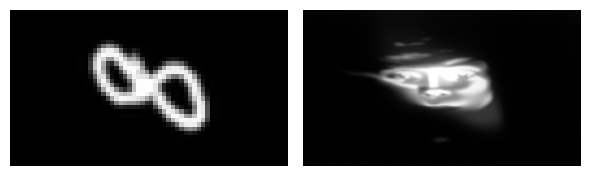

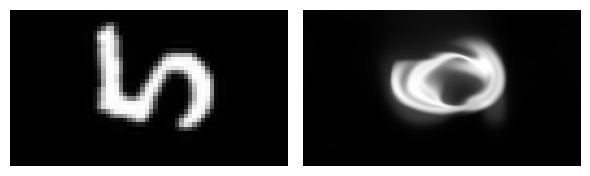

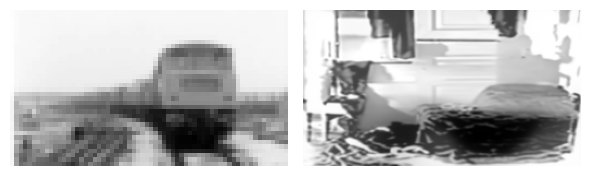

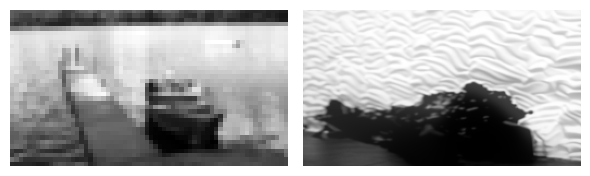

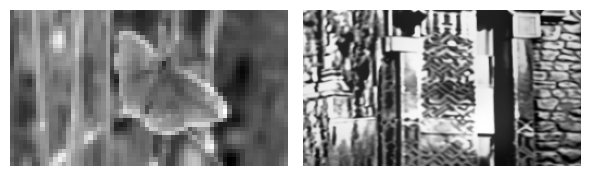

In [174]:
from torchvision import transforms
resize_fn = lambda x: x
resize_fn = transforms.Resize(
    # (int(recons.shape[-2] * config["crop_wins"][sample_data_key][0] / config["crop_wins"][sample_data_key][1]), recons.shape[-1]),
    (int(recons.shape[-2] * gt_imgs.shape[-2] / gt_imgs.shape[-1]), recons.shape[-1]),
    antialias=True
)
for img_i in range(0,36):
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(1, 2, 1)
    ax.imshow(gt_imgs[img_i].cpu().squeeze().unsqueeze(-1), cmap="gray")
    ax.axis("off")
    ax = plt.subplot(1, 2, 2)
    ax.imshow(rgb2gray(resize_fn(recons[img_i].cpu()).permute(1,2,0)), cmap="gray")
    ax.axis("off")
    plt.tight_layout()
    plt.show()
    # plt.imshow(recons[img_i].cpu().squeeze().unsqueeze(-1), cmap="gray")
    # plt.axis("off")
    # plt.show()

### Sensitivity analysis

In [ ]:
### plot results of manual changes to responses (sensitivity)
from csng.utils.mix import plot_comparison

idx = 0
resp_vals_to_try = [1, 20, 100]

resp_std = resp.std(0)
sorted_idx = resp_std.argsort(descending=True)
with torch.no_grad():
    for resp_val in resp_vals_to_try:
        resp_mod = resp.clone()
        resp_mod[:, sorted_idx[idx]] = resp_val
        stim_pred = gan(resp_mod.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_dataset][sample_data_key])

        print(f"resp_val={resp_val:.3f}")
        fig = plot_comparison(target=crop(stim[:8], config["crop_wins"][sample_data_key]).cpu(), pred=crop(stim_pred[:8], config["crop_wins"][sample_data_key]).cpu(), show=True)